In [1]:
import re
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from collections import Counter
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import gutenberg
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer

In [2]:
tokens, sentences = [], []
categories = ['alt.atheism', 'talk.religion.misc', 'sci.space']

newsgroups = fetch_20newsgroups(categories=categories)

for newsgroup in newsgroups.data:
    for lines in newsgroup.split('\n'):
        line = re.sub(r"[^a-zA-Z]+", ' ',lines).lower().strip()
        words = line.split()
        if len(words) != 0:
            tokens.extend(words)

In [3]:
word2int = {}
tokens = list(set(tokens))

for i, token in enumerate(tokens):
    word2int[token] = i

vocab_size = len(word2int)
int2word = {index: token for token, index in word2int.items()}
print('vocab size:', vocab_size)

vocab size: 115065


In [4]:
X = []
Y = []
temp_dict = []
window_size = 2

for i in range(len(tokens)):
    a = i-window_size
    b= i+window_size
    curr_word = tokens[i]
    for z in range(a,i):
        if z >=0:
            temp_dict.append((curr_word, tokens[z]))
    for z in range(i+1,b):
        if z<vocab_size:
            temp_dict.append((curr_word, tokens[z]))

for pair in temp_dict:
    tempx = np.zeros(vocab_size)
    tempy = np.zeros(vocab_size)
    tempx[word2int[pair[0]]] = 1
    tempy[word2int[pair[1]]] = 1
    X.append(tempx)
    Y.append(tempy)

In [8]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
embedding_size = 300
batch_size = 300
epochs = 32 
n_batches = int(len(X)/batch_size)
learning_rate= 0.001

x = tf.placeholder(tf.float32,shape = (None,vocab_size))
y = tf.placeholder(tf.float32,shape = (None,vocab_size))

w1 = tf.Variable(tf.random_normal([vocab_size,embedding_size]),dtype = tf.float32)
b1 = tf.Variable(tf.random_normal([embedding_size]),dtype = tf.float32)
w2 = tf.Variable(tf.random_normal([embedding_size,vocab_size]),dtype = tf.float32)
b2 = tf.Variable(tf.random_normal([vocab_size]),dtype = tf.float32)
hidden_y = tf.matmul(x,w1) + b1
_y = tf.matmul(hidden_y,w2) + b2
#print(b.dtype)
#_y = tf.matmul(x,w)
cost = tf.reduce_mean(tf.losses.mean_squared_error(_y,y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

print(y.shape)
print(_y.shape)

init = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
saver = tf.train.Saver()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.33)
sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))
sess.run(init)

(?, 24018)
(?, 24018)


In [12]:
from tqdm import tqdm

# for epoch in tqdm(range(epochs)):
#     avg_cost = 0
for i in tqdm(range(n_batches-1)):
    batch_x = X[i*batch_size:(i+1)*batch_size]
    batch_y = Y[i*batch_size:(i+1)*batch_size]
    _, c = sess.run([optimizer,cost], feed_dict = {x: batch_x, y: batch_y})
    avg_cost += c / n_batches
print('Epoch 1', avg_cost)

100%|██████████| 239/239 [00:55<00:00,  4.29it/s]Epoch 1 364.3212523142496



In [14]:
embeddings = {}
for i in tqdm(tokens):
    temp_a = np.zeros([1,vocab_size])
    temp_a[0][word2int[i]] = 1
    temp_emb = sess.run([_y],feed_dict = {x:temp_a})
    temp_emb = np.array(temp_emb)
    embeddings[i] = temp_emb.reshape([vocab_size])

100%|██████████| 24018/24018 [01:38<00:00, 242.69it/s]


In [15]:
from collections import OrderedDict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [16]:
def closest(word,n):
    distances = dict()
    for w in embeddings.keys():
        distances[w] = cosine_similarity([embeddings[w]], [embeddings[word]])
    d_sorted = OrderedDict(sorted(distances.items(),key = lambda x:x[1] ,reverse = True))
    s_words = list(d_sorted.keys())
    print('{}: {}'.format(s_words[0], ' '.join(s_words[1:n+1])))

In [17]:
examples = ['king', 'politician', 'news', 'ungodliness', 'asians']

for keyword in examples:
    closest(keyword, 20)

king: liberally eep thrice instituted sea agn seems monoxide inhabitants caltech declared sensing emphases mega srvr updates sympathy postmaster plant toxic
politician: mentalities nonscience thoroughly range brisbane inconclusive nfs forging dcy feature platforms callec satisfactorily passel dresses bango rouben fxn complain recount
news: societies millennia oyster denounce misunderstands british kindergarten stone mutch federation identified jules ethics as emc mullahs plenary steinn nanci coffers
ungodliness: feast pageos chittick hillary consultant peavler venusian satanist properties murnane simplified tradition antarctica brazilians srvr jeremiah occult engineers passes runin
asians: unintentional phad colonization loki embodies mcconley seinem ink prototypes cam exchange ubvms hills catalog long sampling comical gradual allowing heckuba


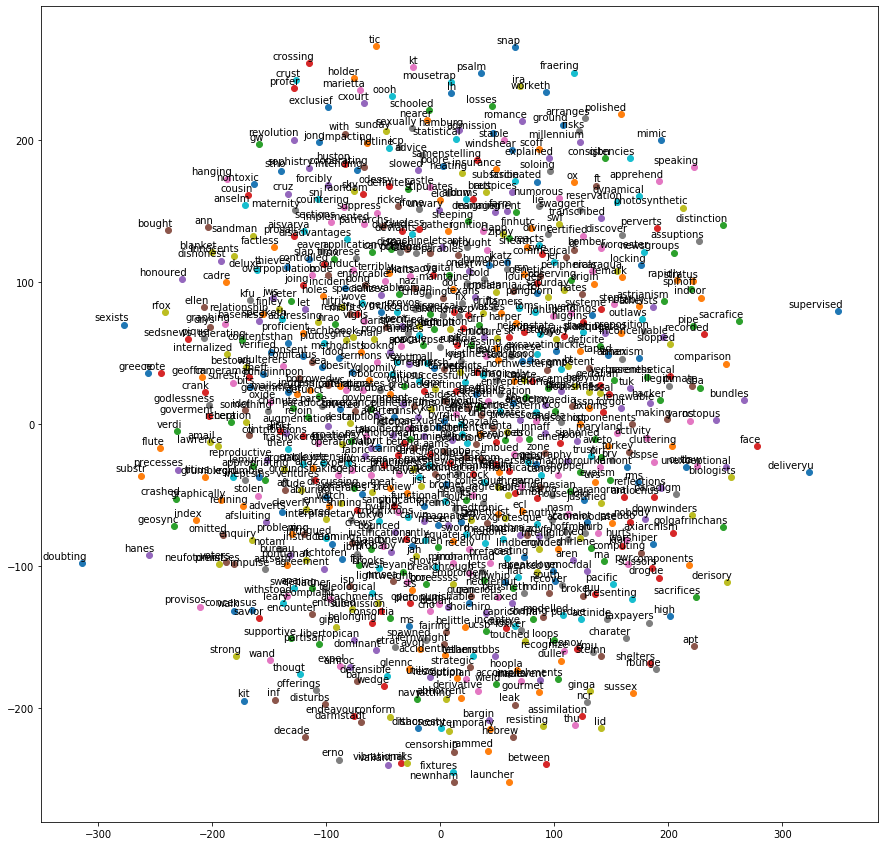

In [18]:
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
new_values = tsne_model.fit_transform(list(embeddings.values())[1:801])

def plot(embeddings, labels):
    plt.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    # plt.xlim(-200, 200)
    # plt.ylim(-200, 200)
    plt.show()
    
plot(new_values, tokens[1:801])

In [42]:
# labels = []
# tokens = []
# for w in list(embeddings.keys())[:500]:
#     labels.append(w)
#     tokens.append(embeddings[w])
# tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
# new_values = tsne_model.fit_transform(tokens)
# x = []
# y = []
# for value in new_values:
#     x.append(value[0])
#     y.append(value[1])
    
# plt.figure(figsize=(16, 16)) 
# for i in range(len(x)):
#     plt.scatter(x[i],y[i])
#     plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
# plt.show()